# Experiment Comparison

The goal of this notebook is to provide a mechanism to review and compare experiments: the cfg, the metrics, and the outcome.

## I. Setup

In [1]:
# project imports
import env
from data.voxels import read_voxel_array, convert_voxels_to_stl, plot_voxels
from data.stl import plot_mesh, read_mesh_vectors
from utils import PROJECT_ROOT, EXPERIMENT_FIG_DIR, read_json_data, flatten_dict, np_recon_loss, unique_savefig_path
from models import MODEL_DIR


# python & package imports
from collections import defaultdict
import pandas as pd
import numpy as np
import json
import os


# plot things
%matplotlib inline
# autoreload modules
%load_ext autoreload
%autoreload 2


model_dir = os.path.join(MODEL_DIR, 'voxel_vaegan1', 'modelnet10')

## II. Experiments

Use this section to save the paths to the experiment model cfgs and checkpoints to be used in later review/comparison sections.

In [2]:
# Experiments

# 500 epochs, just bird
#model = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/2019-03-12_09-30-02/model_epoch-499.ckpt'
# 500 epochs, just bird, increased recon weight
#model = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/2019-03-12_09-38-41/model_epoch-499.ckpt'
# 500 epochs, just bird, dropout 0.8
# early stop
#model = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/2019-03-12_09-44-48/model_epoch-199.ckpt'
# later stop
#model = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/2019-03-12_09-44-48/model_epoch-499.ckpt'
#model = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/2019-03-12_10-22-19/model_epoch-49.ckpt'

# first run with modelnet10
# {'reconstruction_loss': 808.4996337890625, 'dis_loss': -999.0, 'kl_divergence': 488.078369140625, 'dec_loss': -999.0, 'elapsed_time': 43.02408063411713, 'enc_loss': 261.9851379394531}

### vae
best_sofa = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/modelnet10/2019-03-15_10-33-37'
toilet_and_sofa = '/home/jcworkma/jack/3d-form/models/voxel_vaegan1/modelnet10/2019-03-15_12-26-16'
return_to_vae = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/modelnet10/2019-03-23_08-11-20'
return_toilet = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/modelnet10/2019-03-23_08-20-39'
vae_200epochs = os.path.join(MODEL_DIR, 'voxel_vae_toilet_200epochs_1')
# too high of a kl makes a box-like reconstruction with too high of a mean_decoded_output
vae_200epochs_100kl = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/modelnet10/2019-03-24_15-16-59'
vae_200epochs_10kl = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/modelnet10/2019-03-25_01-43-20'
vae_200epochs_p1kl = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/modelnet10/2019-03-25_11-05-00'
vae_200epochs_p1kl_1000latent = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/modelnet10/2019-03-26_05-10-08'
vae_bathtub_toilet = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/modelnet10/2019-03-26_17-02-56'
vae_toilet_nightstand_monitor = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/modelnet10/2019-03-27_05-27-14'
vae_full_index = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/modelnet10/2019-03-28_15-09-00'
vae_modelnet10 = '/home/jcworkma/jack/3d-form/models/voxel_vae_modelnet10_200epochs_1'
vae_modelnet10_64 = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/modelnet10/2019-04-09_05-32-25'

### vaegan
vaegan_sofa13 = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/modelnet10/2019-03-16_13-37-24/model_epoch-13.ckpt'
vaegan_sofa = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/modelnet10/2019-03-16_13-37-24/model_epoch-5.ckpt'
vaegan_decent_toilets_21 = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/modelnet10/2019-03-17_08-40-29'
vaegan_long_toilets = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/modelnet10/2019-03-18_13-12-53'
vaegan_new_losses = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/modelnet10/2019-03-19_19-31-20'
vaegan_1024_filter_discr = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/modelnet10/2019-03-20_09-39-05/'
vaegan_logless_loss = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/modelnet10/2019-03-22_16-01-54'
vaegan_reuse_check = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/modelnet10/2019-03-23_03-48-39'
vaegan_reuse_check2 = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/modelnet10/2019-03-23_04-00-49'
vaegan_reuse_check3 = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/modelnet10/2019-03-23_04-06-01'
vaegan_reuse_check4 = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/modelnet10/2019-03-23_04-09-04'


## III. Reconstruction Test
Here we can reload a model and experiment with reconstructions.

In [5]:
# project imports
from models.voxel_vaegan import VoxelVaegan
from data.modelnet10 import ModelNet10
from data.thingi10k import Thingi10k
from data.voxels import plot_voxels
from utils import read_json_data


# python & package projects
import tensorflow as tf
import numpy as np

tf.reset_default_graph()

# model to use for reconstruction
model_root = os.path.join(PROJECT_ROOT, vae_modelnet10_64)
model_cfg = read_json_data(os.path.join(model_root, 'cfg.json'))
#model_ckpt = os.path.join(model_root, 'model_epoch-129.ckpt')
model_ckpt = os.path.join(model_root, 'model_epoch-_end.ckpt')

# move the cfg from gpu to cpu to avoid clashing with any models currently training on gpu
#model_cfg['model']['gpu'] = False
#voxels_dim = model_cfg['model']['voxels_dim']

# restore the model from ckpt
#vaegan = VoxelVaegan.initFromCfg(model_cfg)
#vaegan.restore(model_ckpt)

### III. A. From Dataset Example

['toilet' 'dresser' 'bed' 'chair' 'night_stand' 'sofa' 'bathtub' 'monitor'
 'table']
('bed', 'train', 'bed_0407_32_x0_z0.binvox')


ValueError: too many values to unpack (expected 2)

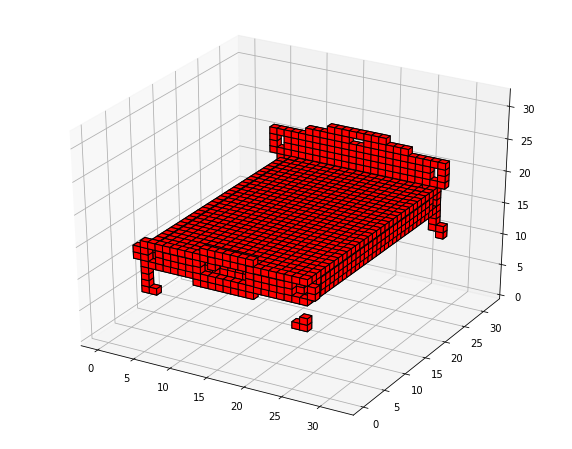

In [15]:
def get_example(random=True, category=None, name=None, plot=True, voxels_dim=32):
    """
    Returns an example from the dataset and optionally plots
    
    Args:
        random: bool, if True, will get random voxel
        name: tuple (category, dataset, name), will return named example
        
    Returns:
        training_input: np.array, exact voxel in original dims
        training_example: np.array, voxel in reshaped-for-model dims
    """
    dataset_class = model_cfg.get('dataset').get('class')
    dataset_index = model_cfg.get('dataset').get('index')
    dataset_categories = model_cfg.get('dataset').get('categories', None)
    if dataset_class == 'Thingi10k':
        # get an stl example
        thingi = Thingi10k.init10k()
        stl_example = thingi.get_stl_path(stl_id=126660)
        training_input = thingi.get_voxels(voxels_dim, stl_file=stl_example)
    elif dataset_class == 'ModelNet10':
        modelnet = ModelNet10.initFromIndex(dataset_index)
        modelnet.filter_x_z(0, 0)
        if dataset_categories:
            modelnet.filter_categories(dataset_categories)
            print(modelnet.df.category.unique())
        if category:
            modelnet.filter_categories([category])
        if name:
            training_input = modelnet.get_voxels(name[0], name[1], name[2])
        elif random:
            name, training_input = modelnet.get_random_voxels(voxels_dim)
        print(name)

    #training_input = modelnet.get_voxels('toilet', 'train', 'toilet_0056_32_x0_z0.binvox')
    #training_input = modelnet.get_voxels('bathtub', 'train', 'bathtub_0082_32_x0_z0.binvox')

    example_plot = None
    if plot:
        example_plot = plot_voxels(training_input, figsize=(10, 8))
    training_example = np.reshape(training_input, (-1, voxels_dim, voxels_dim, voxels_dim, 1))
    
    return training_input, training_example, name, example_plot


#training_input, training_example = get_example(name=('chair', 'train', 'chair_0169_32_x0_z0.binvox'))
training_input, training_example = get_example(name=('bed', 'train', 'bed_0407_32_x0_z0.binvox'))

#training_input, training_example, example_name, example_plot = get_example(category='bed', voxels_dim=64)
example_plot.savefig(os.path.join(EXPERIMENT_FIG_DIR, '{}.orig.png'.format(example_name)))

#training_input, training_example = get_example(voxels_dim=64)

# bad voxels:
# toilet_0211_32_x0_z3.binvox is an empty array!
# bed_0010_32_x0_z0.binvox

In [104]:
print(training_example.shape)
recon = vaegan.reconstruct(training_example)
recon = np.reshape(recon, [voxels_dim, voxels_dim, voxels_dim])
print('max: ', np.max(recon))
print('min: ', np.min(recon))
print('mean: ', np.mean(recon))
print('loss: ', np_recon_loss(training_input, recon))

(1, 64, 64, 64, 1)
max:  0.9995235
min:  0.0
mean:  0.113194905
loss:  0.0049911924


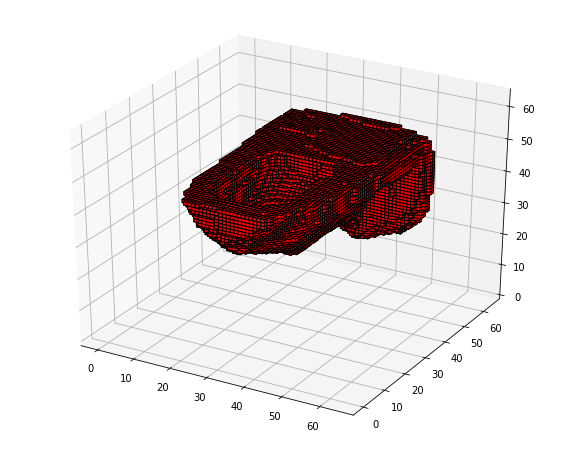

In [105]:
recon_threshold = recon > .9
fig = plot_voxels(recon_threshold, figsize=(10, 8))
fig.savefig(unique_savefig_path('{}.recon'.format(example_name)))

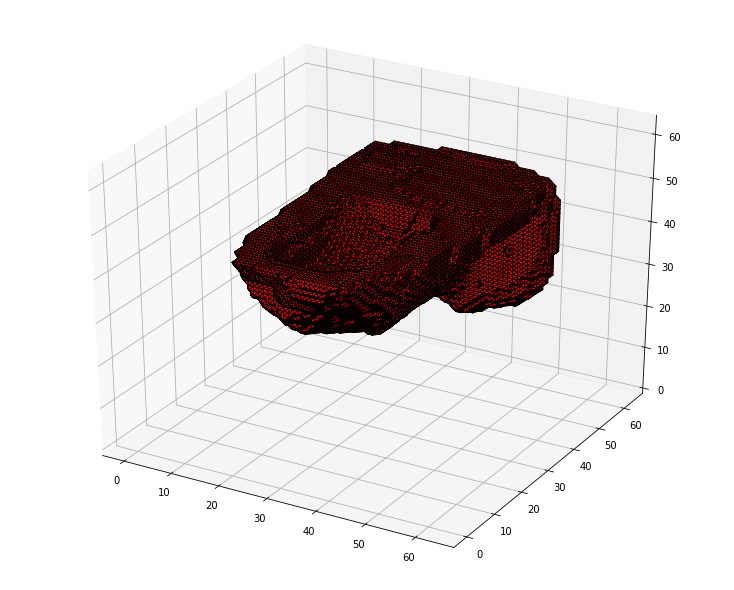

In [106]:
# convert to stl
stl_mesh = convert_voxels_to_stl(recon_threshold)
fig = plot_mesh(stl_mesh, figsize=(10, 8))
fig.savefig(unique_savefig_path('{}.stl.recon'.format(example_name)))

### III. B. From Latent Vector

Thank you: https://github.com/tayden/VAE-Latent-Space-Explorer/blob/master/scripts/VAE.ipynb

In [13]:
latent_vector = vaegan.random_latent_vector(mu=.5, sig=.7)
recon = vaegan.latent_recon(latent_vector)
recon = np.reshape(recon, [32, 32, 32])
print('max: ', np.max(recon))
print('min: ', np.min(recon))
print('mean: ', np.mean(recon))

max:  1.0
min:  0.0
mean:  0.032674734


<module 'matplotlib.pyplot' from '/home/jcworkma/jack/3d-form/.3d-form/lib/python3.5/site-packages/matplotlib/pyplot.py'>

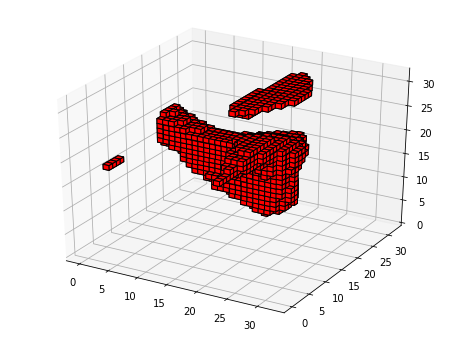

In [14]:
recon_threshold = recon > .2
plot_voxels(recon_threshold)

## III. C. From External Example

NameError: name 'voxels_dim' is not defined

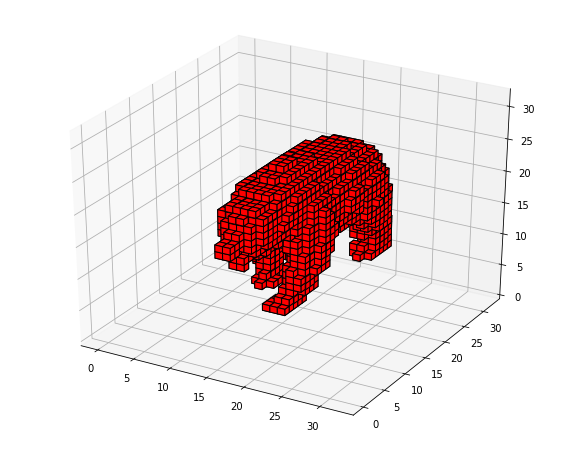

In [17]:
# airplanes from shapenet
#ext_example = os.path.join(PROJECT_ROOT, 'data/external/ShapeNetCore.v2/02691156/110f6dbf0e6216e9f9a63e9a8c332e52/models/model_normalized.binvox')
#ext_example = os.path.join(PROJECT_ROOT, 'data/external/ShapeNetCore.v2/02691156/617993bd3425d570ca2bd098b9203af/models/model_normalized.binvox')
#ext_example = os.path.join(PROJECT_ROOT, 'data/external/ShapeNetCore.v2/02691156/ddec69970cbc4d29112a90660b187a10/models/model_normalized.binvox')

# cars from shapenet
#ext_example = os.path.join(PROJECT_ROOT, 'data/external/ShapeNetCore.v2/02958343/5523a6798194043146810e868f84ab51/models/model_normalized.binvox')
#ext_example = os.path.join(PROJECT_ROOT, 'data/external/ShapeNetCore.v2/02958343/301d1c48d321d29f5d2921c9c16f3c69/models/model_normalized.binvox')
# school bus from shapenet
#ext_example = os.path.join(PROJECT_ROOT, 'data/external/ShapeNetCore.v2/02924116/7e1ebfe89513837f4b49e2e4c84b2e43/models/model_normalized.binvox')

#ext_example = os.path.join(PROJECT_ROOT, 'data/external/downloaded_stls/Stang_high_poly.binvox')
#ext_example = os.path.join(PROJECT_ROOT, 'data/external/downloaded_stls/Sow_64.binvox')
#ext_example = os.path.join(PROJECT_ROOT, 'data/external/downloaded_stls/Gshepherd_64.binvox')
#ext_example = os.path.join(PROJECT_ROOT, 'data/external/downloaded_stls/Pig_64.binvox')
#ext_example = os.path.join(PROJECT_ROOT, 'data/external/downloaded_stls/Sheep_64.binvox')
#ext_example = os.path.join(PROJECT_ROOT, 'data/external/downloaded_stls/Lemon.binvox')
#ext_example = os.path.join(PROJECT_ROOT, 'data/external/downloaded_stls/CHIKEN_64.binvox')
#ext_example = os.path.join(PROJECT_ROOT, 'data/external/downloaded_stls/Cat_64.binvox')
#ext_example = os.path.join(PROJECT_ROOT, 'data/external/downloaded_stls/chili.binvox')
#ext_example = os.path.join(PROJECT_ROOT, 'data/external/downloaded_stls/pig_low_64.binvox')

#ext_example = os.path.join(PROJECT_ROOT, 'data/external/downloaded_stls/Chick_64.binvox')
#ext_example = os.path.join(PROJECT_ROOT, 'data/external/downloaded_stls/R8_high_poly_64.binvox')
#ext_example = os.path.join(PROJECT_ROOT, 'data/external/downloaded_stls/Lambo_high_poly_64.binvox')
#ext_example = os.path.join(PROJECT_ROOT, 'data/external/downloaded_stls/911_high_poly_64.binvox')
#ext_example = os.path.join(PROJECT_ROOT, 'data/external/downloaded_stls/chili_64.binvox')
#ext_example = os.path.join(PROJECT_ROOT, 'data/external/downloaded_stls/Elise_high_poly.binvox')
#ext_example = os.path.join(PROJECT_ROOT, 'data/external/downloaded_stls/Bear_64.binvox')
ext_example = os.path.join(PROJECT_ROOT, 'data/external/downloaded_stls/Bear.binvox')
#ext_example = os.path.join(PROJECT_ROOT, 'data/external/downloaded_stls/RABBIT_64.binvox')
#ext_example = os.path.join(PROJECT_ROOT, 'data/external/downloaded_stls/Donkey_64.binvox')
#ext_example = os.path.join(PROJECT_ROOT, 'data/external/downloaded_stls/MilkCow_64.binvox')
#ext_example = os.path.join(PROJECT_ROOT, 'data/external/downloaded_stls/apple_64.binvox')
#ext_example = os.path.join(PROJECT_ROOT, 'data/external/downloaded_stls/Cow_64.binvox')
#ext_example = os.path.join(PROJECT_ROOT, 'data/external/downloaded_stls/HORSE_64.binvox')

ext_name = os.path.basename(ext_example)
ext_voxels = read_voxel_array(ext_example).data
ext_fig = plot_voxels(ext_voxels, figsize=(10, 8))
ext_fig.savefig(os.path.join(EXPERIMENT_FIG_DIR, '{}.orig.png'.format(ext_name)))
ext_voxels = np.reshape(ext_voxels, (-1, voxels_dim, voxels_dim, voxels_dim, 1))

In [113]:
recon = vaegan.reconstruct(ext_voxels)
recon = np.reshape(recon, [voxels_dim, voxels_dim, voxels_dim])
print('max: ', np.max(recon))
print('min: ', np.min(recon))
print('mean: ', np.mean(recon))

max:  1.0
min:  0.0
mean:  0.08655305


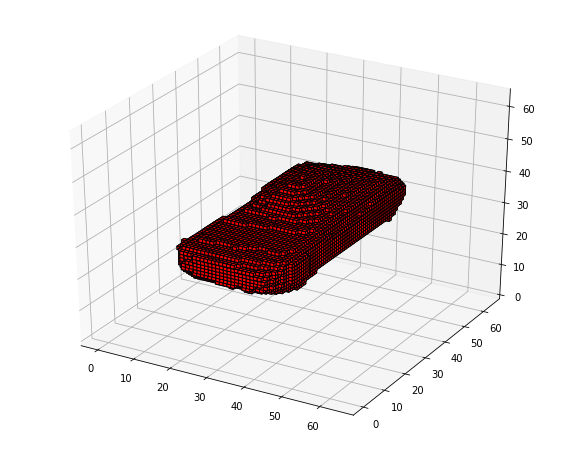

In [114]:
recon_threshold = recon > .9
fig = plot_voxels(recon_threshold, figsize=(10, 8))
fig.savefig(unique_savefig_path('{}.recon'.format(ext_name)))

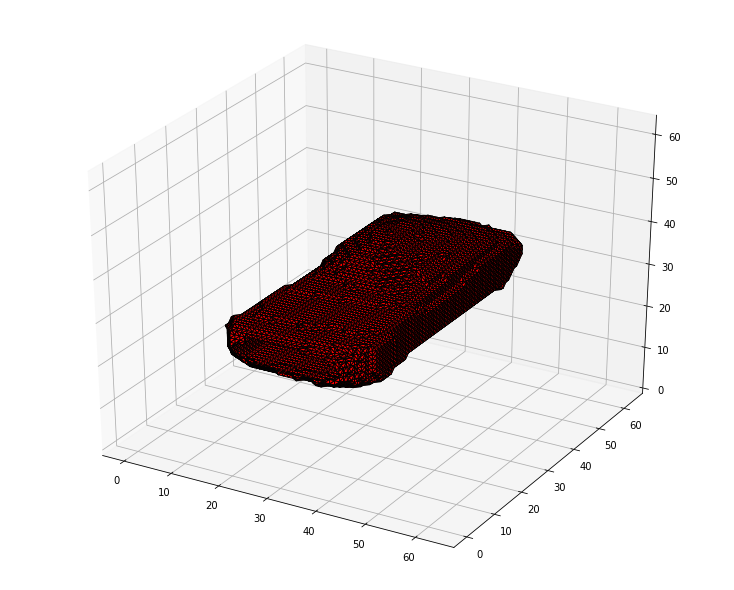

In [115]:
# convert to stl
stl_mesh = convert_voxels_to_stl(recon_threshold)
fig = plot_mesh(stl_mesh, figsize=(10, 8))
fig.savefig(unique_savefig_path('{}.stl.recon'.format(ext_name)))

## IV. Object Mashup

### Method 1

('chair', 'train', 'chair_0169_32_x0_z0.binvox')
chair_0668_32_x0_z0.binvox


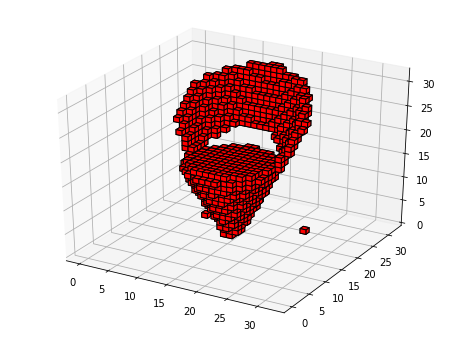

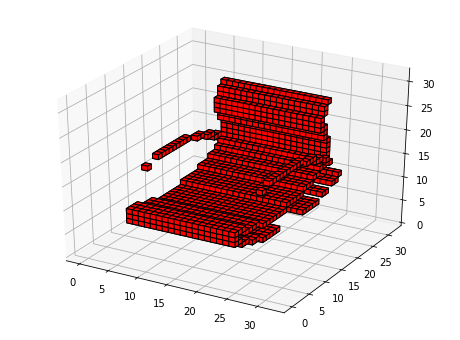

In [43]:
#input1, ex1 = get_example(name=('table', 'train', 'table_0272_32_x0_z0.binvox'))
input1, ex1 = get_example(name=('chair', 'train', 'chair_0169_32_x0_z0.binvox'))
#input1, ex1 = get_example(category='toilet')
#input1, ex1 = get_example(category='toilet')
input2, ex2 = get_example(category='chair')

In [30]:
mashed = vaegan.mashup_interpolation(ex1, ex2)
print(mashed.shape)

(10, 32, 32, 32, 1)


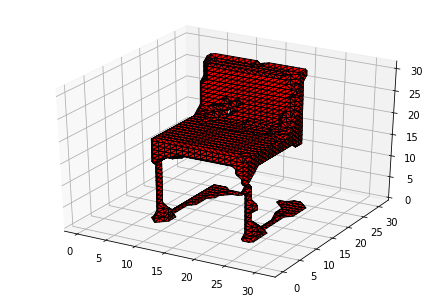

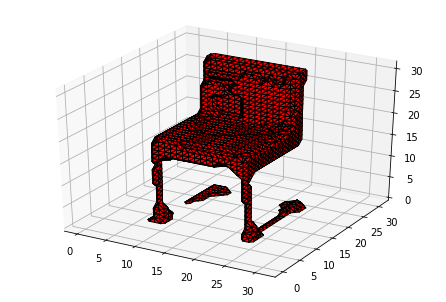

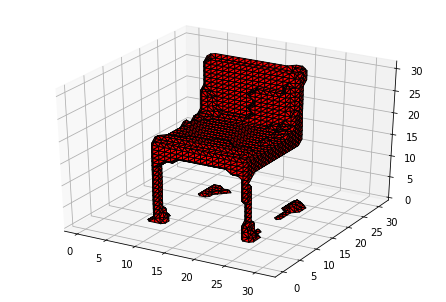

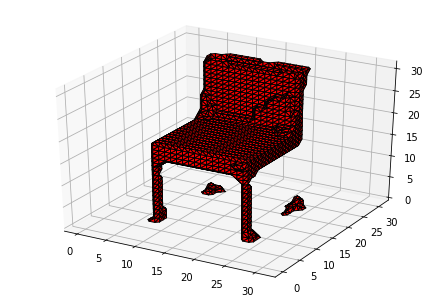

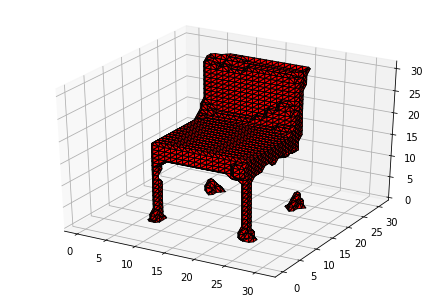

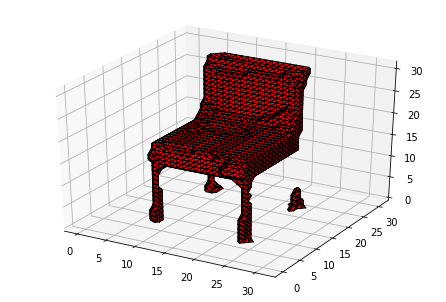

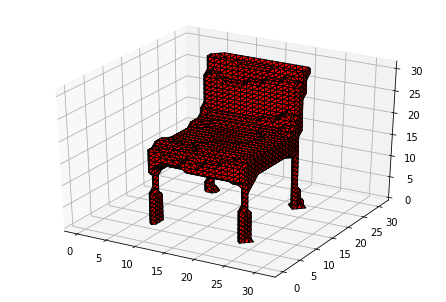

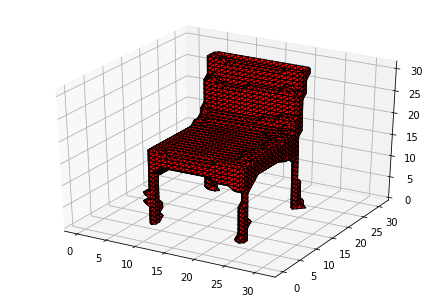

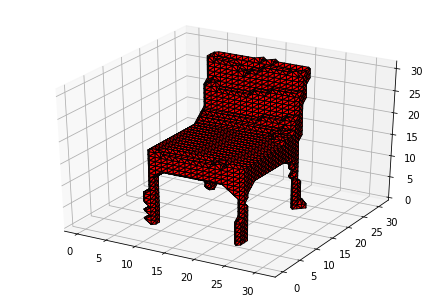

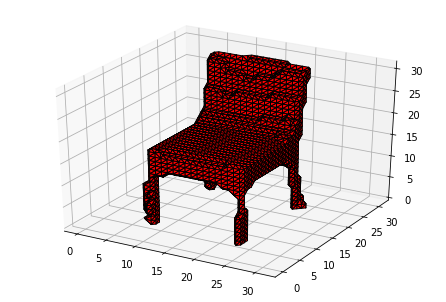

In [31]:
for m in mashed:
    m = np.reshape(m, (32, 32, 32))
    #print('max: ', np.max(m))
    #print('min: ', np.min(m))
    #print('mean: ', np.mean(m))
    m_threshold = m > .9
    #plot_voxels(m_threshold)
    stl_data = convert_voxels_to_stl(m_threshold)
    plot_mesh(stl_data)

### Method 2

In [97]:
### Mashup with vector addition
#ext_example1 = os.path.join(PROJECT_ROOT, 'data/external/downloaded_stls/apple.binvox')
#ext_example1 = os.path.join(PROJECT_ROOT, 'data/external/downloaded_stls/Zilla_high_poly.binvox')
#ext_example2 = os.path.join(PROJECT_ROOT, 'data/external/downloaded_stls/Zilla_low_poly.binvox')
#ext_example2 = os.path.join(PROJECT_ROOT, 'data/external/downloaded_stls/R8_high_poly.binvox')
#ext_example1 = os.path.join(PROJECT_ROOT, 'data/external/downloaded_stls/Elise_high_poly.binvox')
#ext_example = os.path.join(PROJECT_ROOT, 'data/external/downloaded_stls/chili.binvox')
#ext_example1 = os.path.join(PROJECT_ROOT, 'data/external/downloaded_stls/Pig.binvox')
#ext_example1 = os.path.join(PROJECT_ROOT, 'data/external/downloaded_stls/Bear.binvox')
ext_example2 = os.path.join(PROJECT_ROOT, 'data/external/downloaded_stls/CHIKEN_64.binvox')
# car from shapenet
#ext_example2 = os.path.join(PROJECT_ROOT, 'data/external/ShapeNetCore.v2/02958343/301d1c48d321d29f5d2921c9c16f3c69/models/model_normalized.binvox')
# school bus from shapenet
#ext_example2 = os.path.join(PROJECT_ROOT, 'data/external/ShapeNetCore.v2/02924116/7e1ebfe89513837f4b49e2e4c84b2e43/models/model_normalized.binvox')

#ext_example2 = os.path.join(PROJECT_ROOT, 'data/external/downloaded_stls/chili.binvox')
#ext_example2 = os.path.join(PROJECT_ROOT, 'data/external/downloaded_stls/RABBIT.binvox')

# good chicken chair
input1, ex1, _, ex_name = get_example(plot=False, voxels_dim=voxels_dim, name=('chair', 'train', 'chair_0169_64_x0_z0.binvox'))
#input1 = read_voxel_array(ext_example1).data
input2 = read_voxel_array(ext_example2).data
#ex1 = np.reshape(input1, (-1, 32, 32, 32, 1))
ex2 = np.reshape(input2, (-1, voxels_dim, voxels_dim, voxels_dim, 1))

latent1 = vaegan.encode(ex1)
#ex2 = np.reshape(np.rot90(input2), (1, 32, 32, 32, 1))
latent2 = vaegan.encode(ex2)
#crossed = np.cross(latent1, latent2)
mid = latent1 + latent2

['toilet' 'dresser' 'bed' 'chair' 'night_stand' 'sofa' 'bathtub' 'monitor'
 'table']
('chair', 'train', 'chair_0169_64_x0_z0.binvox')


In [95]:
recon = vaegan.latent_recon(mid)
recon = np.reshape(recon, [voxels_dim, voxels_dim, voxels_dim])
print('max: ', np.max(recon))
print('min: ', np.min(recon))
print('mean: ', np.mean(recon))

max:  1.0
min:  0.0
mean:  0.12341784


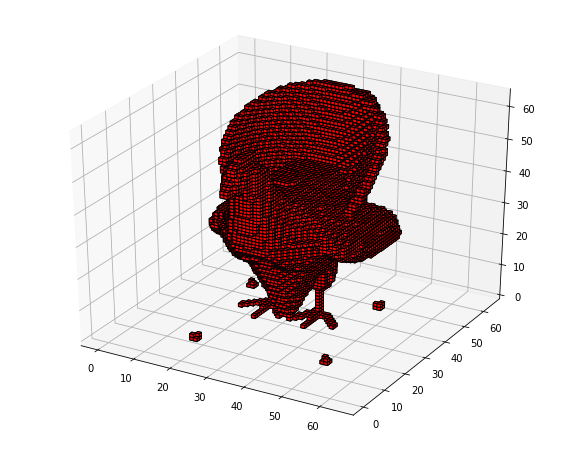

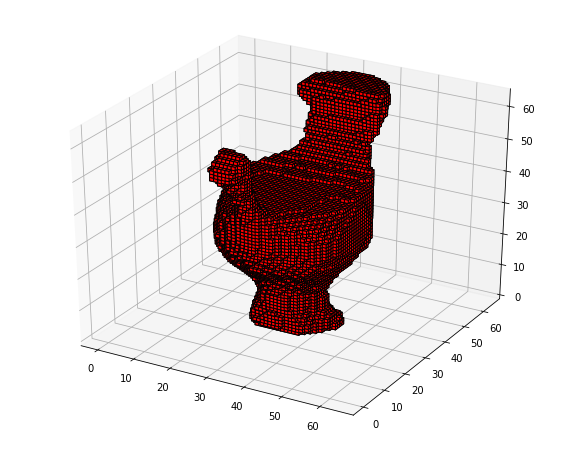

In [102]:
# baseline
baseline = input1 + input2
fig = plot_voxels(baseline, figsize=(10, 8))
fig.savefig(unique_savefig_path('{}.{}.baseline'.format(os.path.basename(ext_example2), ex_name)))
recon_threshold = recon > .9
fig = plot_voxels(recon_threshold, figsize=(10, 8))
fig.savefig(unique_savefig_path('{}.{}.recon'.format(os.path.basename(ext_example2), ex_name)))

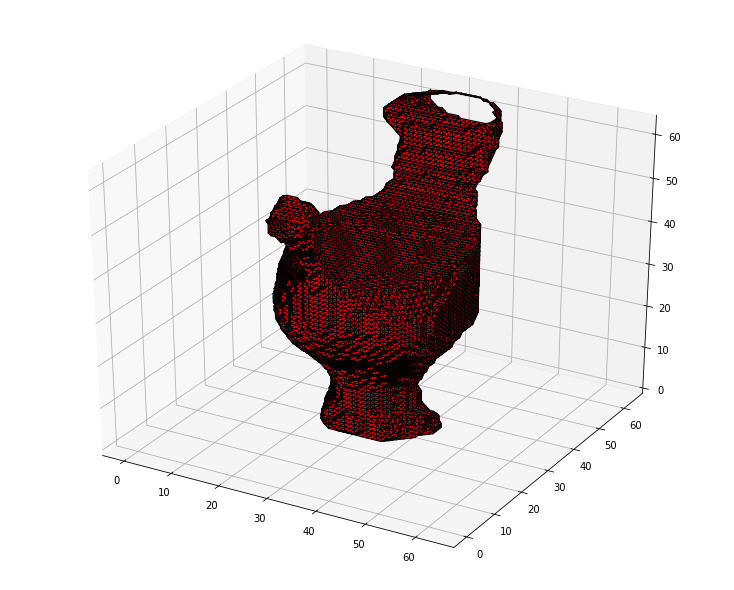

In [100]:
# convert to stl
stl_mesh = convert_voxels_to_stl(recon_threshold)
fig = plot_mesh(stl_mesh, figsize=(10, 8))
fig.savefig(unique_savefig_path('{}.{}.recon'.format(os.path.basename(ext_example2), ex_name)))

NameError: name 'ext_example2' is not defined

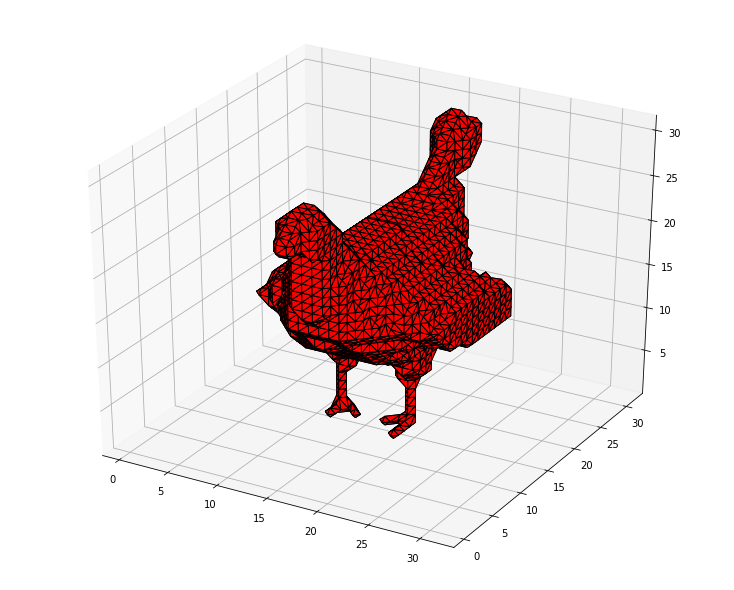

In [6]:
stl_mesh = read_mesh_vectors('../src/reports/demos/good_combos/CHICKEN.orig.binvox.stl')
fig = plot_mesh(stl_mesh, figsize=(10, 8))
fig.savefig(unique_savefig_path('{}.{}.recon'.format(os.path.basename(ext_example2), ex_name)))

## V. Model Leaderboard

This section iterates through all directories in the model dir and extracts their loss values. We can use this section to review past experiments and see which ones yielded positive results.

In [22]:
scores = dict()
for m in os.listdir(model_dir):
    name = m
    metrics_json = os.path.join(model_dir, m, 'metrics.json')
    #print(metrics_json)
    #if os.path.exists(metrics_json):
    #    df = pd.read_json(metrics_json, orient='values')
    #    break
    metrics_dict = read_json_data(metrics_json)
    if metrics_dict:
        # assuming only keys are epoch\d+
        keys = [int(key.replace('epoch', '')) for key in metrics_dict.keys()]
        last_epoch = sorted(keys)[-1]
        last_key = 'epoch{}'.format(last_epoch)
        scores[name] = metrics_dict[last_key]
        scores[name]['epoch'] = last_epoch

df = pd.DataFrame.from_dict(scores, orient='index')

In [51]:
#df.sort_values('elapsed_time', ascending=False)
df

,enc_loss,ll_loss,dec_loss,epoch,elapsed_time,kl_divergence,dis_loss,reconstruction_loss
2019-03-14_15-51-00,305.875122,NaN,-999.000000,9,35.956132,5.801771e+02,-999.000000,3414.346680
2019-03-14_16-33-24,302.278900,NaN,-999.000000,9,36.155712,5.931022e+02,-999.000000,3353.308350
2019-03-14_17-18-00,158.275955,NaN,-999.000000,9,36.349445,4.334231e+03,-999.000000,1631.519775
2019-03-14_18-13-26,NaN,NaN,-999.000000,24,214.388031,NaN,-999.000000,NaN
2019-03-15_10-33-37,123.401489,NaN,-999.000000,9,75.421927,5.041918e+02,-999.000000,352.732208
2019-03-15_12-26-16,167.426086,NaN,-999.000000,9,122.187959,6.310500e+02,-999.000000,484.000122
2019-03-15_17-08-43,141.617874,NaN,-999.000000,14,166.663848,1.152593e+03,-999.000000,346.030945
2019-03-16_02-31-22,134.447601,NaN,-999.000000,14,164.438432,1.194335e+03,-999.000000,318.271698
2019-03-16_12-42-35,24583.722656,2.458372e+04,24584.394531,0,23.573650,4.565747e-03,0.251363,0.065873
2019-03-16_13-37-24,21992.787109,2.199279e+04,21993.357422,13,341.012416,1.263916e-04,3.597789,0.057477


## VI. Config Comparison

Use this section to compare configs between two experiments. This can be useful when determining what yielded positive results in previous runs.

In [199]:
cfg1 = read_json_data(os.path.join(vae_200epochs, 'cfg.json'), verbose=True)
cfg2 = read_json_data(os.path.join(vae_200epochs_10kl, 'cfg.json'), verbose=True)
assert isinstance(cfg1, dict)
assert isinstance(cfg2, dict)

# flatten dict structure then bring into pandas for a pretty view
cfg1 = flatten_dict(cfg1)
cfg2 = flatten_dict(cfg2)
df1 = pd.DataFrame.from_dict(cfg1, orient='index', columns=['cfg1'])
df2 = pd.DataFrame.from_dict(cfg2, orient='index', columns=['cfg2'])
dff = pd.concat([df1, df2], axis=1, sort=False)
dff['diff'] = dff.cfg1 == dff.cfg2
dff

,cfg1,cfg2,diff
generator/verbose,True,True,True
model/batch_size,128,128,True
model/dis_lr,0.0001,0.0001,True
dataset/class,ModelNet10,ModelNet10,True
model/launch_tensorboard,True,True,True
model/no_gan,True,True,True
model/voxels_dim,32,32,True
dataset/index,/home/jcworkma/jack/3d-form/src/../data/proces...,/home/jcworkma/jack/3d-form/src/../data/proces...,True
model/input_repeats,1,1,True
model/verbose,True,True,True


## VII. Experiment Log Monitoring

This section dumps the tail of the specified log. Use it to see the latest status of an ongoing experiment (in case jupyter notebook lost connection) or to review how many epochs a certain experiment trained for.

In [20]:
!tail /home/jcworkma/jack/3d-form/src/logs/2019-04-11_19-52__root.log

2019-04-15 12:11:51,678 - DEBUG - voxel_vaegan: Epoch: 171 / 200, Batch: 1278 (20464 / 58144), Elapsed time: 5299.59 mins
2019-04-15 12:11:52,143 - INFO - voxel_vaegan: Enc Loss = 39.33, KL Divergence = 144.66, Reconstruction Loss = 0.00, ll_loss = -999.00, dis_Loss = -999.00, dec_Loss = -999.00, Elapsed time: 5299.60 mins
2019-04-15 12:11:52,145 - INFO - voxel_vaegan: Memory Use (GB): 2.2950439453125
2019-04-15 12:11:52,190 - DEBUG - voxel_vaegan: Epoch: 171 / 200, Batch: 1279 (20480 / 58144), Elapsed time: 5299.60 mins
2019-04-15 12:11:52,643 - INFO - voxel_vaegan: Enc Loss = 44.20, KL Divergence = 146.15, Reconstruction Loss = 0.00, ll_loss = -999.00, dis_Loss = -999.00, dec_Loss = -999.00, Elapsed time: 5299.61 mins
2019-04-15 12:11:52,646 - INFO - voxel_vaegan: Memory Use (GB): 2.2950439453125
2019-04-15 12:11:52,687 - DEBUG - voxel_vaegan: Epoch: 171 / 200, Batch: 1280 (20496 / 58144), Elapsed time: 5299.61 mins
2019-04-15 12:11:53,154 - INFO - voxel_vaegan: Enc Loss = 40.78, KL 

## VIII. Model Summary

In [57]:
vaegan.model_summary()

---------
Variables: name (type shape) [size]
---------
encoder/conv3d/kernel:0 (float32_ref 3x3x3x1x8) [216, bytes: 864]
encoder/conv3d/bias:0 (float32_ref 8) [8, bytes: 32]
encoder/enc_conv1/gamma:0 (float32_ref 8) [8, bytes: 32]
encoder/enc_conv1/beta:0 (float32_ref 8) [8, bytes: 32]
encoder/conv3d_1/kernel:0 (float32_ref 3x3x3x8x16) [3456, bytes: 13824]
encoder/conv3d_1/bias:0 (float32_ref 16) [16, bytes: 64]
encoder/batch_normalization/gamma:0 (float32_ref 16) [16, bytes: 64]
encoder/batch_normalization/beta:0 (float32_ref 16) [16, bytes: 64]
encoder/conv3d_2/kernel:0 (float32_ref 3x3x3x16x32) [13824, bytes: 55296]
encoder/conv3d_2/bias:0 (float32_ref 32) [32, bytes: 128]
encoder/batch_normalization_1/gamma:0 (float32_ref 32) [32, bytes: 128]
encoder/batch_normalization_1/beta:0 (float32_ref 32) [32, bytes: 128]
encoder/conv3d_3/kernel:0 (float32_ref 3x3x3x32x64) [55296, bytes: 221184]
encoder/conv3d_3/bias:0 (float32_ref 64) [64, bytes: 256]
encoder/batch_normalization_2/gamma:0 